In [2]:
from clustering_helper import *
from clustering_basic import kmeans_clustering as kc
from clustering_basic import diametrical_clustering as dc
from clustering_grassmannian import grassmannian_clustering_chordal as gcc
from clustering_grassmannian import grassmannian_clustering_geodesic as gcg
from clustering_grassmannian import weighted_grassmann_clustering as wgc
import pickle
import os

from IPython.display import clear_output

In [30]:
def get_data(p, K):
    synth_data = np.loadtxt('synthetic_new/synth_data_MACG_p'+str(p)+'K'+str(K)+'_1.csv',delimiter=',')
    n = synth_data.shape[0]
    data_gr = np.zeros((int(n/2),p,2))
    data_gr[:,:,0] = synth_data[np.arange(n,step=2),:] # first frame
    data_gr[:,:,1] = synth_data[np.arange(n,step=2)+1,:] # second frame
    data_sphere = data_gr[:,:,0]
    return data_sphere, data_gr


def synthdat(pK_comb, method_dict, N_seed):
    c_dict = {}
    for p,K in tqdm(pK_comb):
        for seed in tqdm(range(N_seed), leave=False):
            _, data_gr = get_data(p,K)
            for method, cc in method_dict.items():
                try:
                    c_dict[(p,K,method)] = cc(data_gr, K, seed)
                except Exception as e:
                    print("\n",p,K,method)
                    print("Error: ", e)
    return c_dict

def fix_missing(c_dict, pK_comb, method_dict, N_seed, N, noise_scale):
    all_comb = [(p,K,method,seed) for p,K in pK_comb for method in method_dict.keys() for seed in range(N_seed)]
    missing_comb = []

    for p,K,method,seed in all_comb:
        if (p,K,seed,method) in c_dict: continue
        else: missing_comb.append((p,K,seed,method))
    print(len(missing_comb))

    for p,K,seed,method in tqdm(missing_comb):
        _, data_gr, data_eigvals = get_data(p,K,N,noise_scale,seed=seed)
        if method == "wgc": c_data = wgc(data_gr, data_eigvals, K)
        else: c_data = method_dict[method](data_gr, K)
        c_dict[(p,K,seed,method)] = c_data

    return c_dict

def get_plot_dict(c_dict):
    # import pickle
    from collections import defaultdict
    plot_dict = defaultdict(list)

    # c_dict_loaded = pickle.load(open("clustering_dict.pkl", "rb"))
    for c_vars, c_data in c_dict.items():
        if isinstance(c_data, str): continue
        if len(c_vars) == 4: p,K,seed,method = c_vars
        else: p,K,method = c_vars
        
        if method=="wgc": centroids,weights,labels,obj = c_data
        else: centroids,labels,obj = c_data
        
        true_labels = get_true_labels(K,N)
        plot_dict[(p,K,method)] += [calc_NMI(labels, true_labels)]
    return plot_dict

plot_dict_median = lambda plot_dict: {(p,K,method): np.median(NMI_list) for (p,K,method),NMI_list in plot_dict.items()}


method_dict = {"kc":kc, "dc":dc, "gcc":gcc, "wgc":wgc}

N_seed = 10
N = 5_000
noise_scale = 1.5

In [3]:
def get_data(p, K):
    synth_data = np.loadtxt('synthetic_new/synth_data_MACG_p'+str(p)+'K'+str(K)+'_1.csv',delimiter=',')
    n = synth_data.shape[0]
    data_gr = np.zeros((int(n/2),p,2))
    data_gr[:,:,0] = synth_data[np.arange(n,step=2),:] # first frame
    data_gr[:,:,1] = synth_data[np.arange(n,step=2)+1,:] # second frame
    data_sphere = data_gr[:,:,0]
    return data_sphere, data_gr


def synthdat(pK_comb, method_dict, N_seed):
    c_dict = {}
    for p,K in tqdm(pK_comb):
        for _ in tqdm(range(N_seed), leave=False):
            _, data_gr = get_data(p,K)
            for method, cc in method_dict.items():
                try:
                    c_dict[(p,K,method)] = cc(data_gr, K)
                except Exception as e:
                    print("\n",p,K,method)
                    print("Error: ", e)
    return c_dict

N_seed = 10
N = 10_000

pK_comb = [(p, K) for p in [4, 5, 10, 15, 25, 30, 40, 50] for K in [4, 5, 6, 7, 8, 10] if p>=K]
method_dict = {"kc":kc, "dc":dc, "gcc":gcc}

c_dict = synthdat(pK_comb, method_dict, N_seed)

100%|██████████| 39/39 [22:51<00:00, 35.17s/it]


In [ ]:
def synthdat(pK_comb, method_dict, N_seed):
    c_dict = {}
    for p,K in tqdm(pK_comb):
        for _ in tqdm(range(N_seed), leave=False):
            _, data_gr = get_data(p,K)
            for method, cc in method_dict.items():
                try:
                    c_dict[(p,K,method)] = cc(data_gr, K)
                except Exception as e:
                    print("\n",p,K,method)
                    print("Error: ", e)
    return c_dict

In [28]:
def get_plot_dict(c_dict):
    # import pickle
    from collections import defaultdict
    plot_dict = defaultdict(list)

    # c_dict_loaded = pickle.load(open("clustering_dict.pkl", "rb"))
    for c_vars, c_data in c_dict.items():
        if isinstance(c_data, str): continue
        if len(c_vars) == 4: p,K,seed,method = c_vars
        else: p,K,method = c_vars
        
        if method=="wgc": centroids,weights,labels,obj = c_data
        else: centroids,labels,obj = c_data
        
        true_labels = get_true_labels(K,N=len(labels))
        plot_dict[(p,K,method)] += [calc_NMI(labels, true_labels)]
    return plot_dict

plot_dict = get_plot_dict(c_dict)

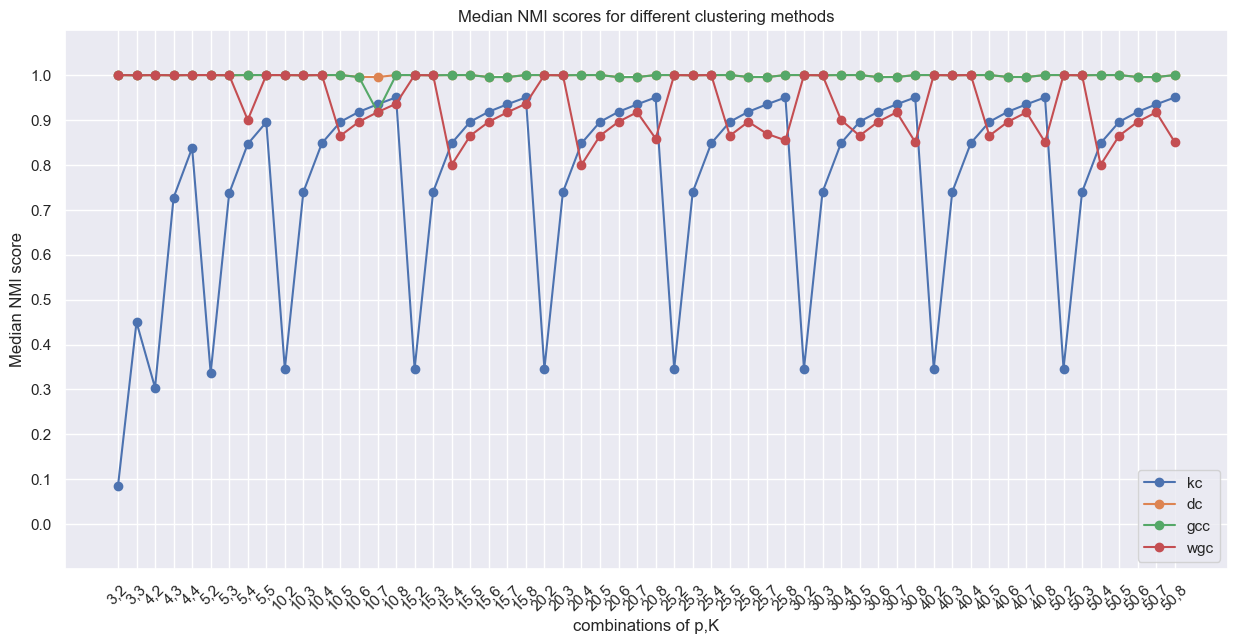

In [12]:
from seaborn import set_theme
set_theme()

c_dict_3 = pickle.load(open("clustering_MACG_0.5.pkl", "rb"))
plot_dict = get_plot_dict(c_dict_3)
median_dict = plot_dict_median(plot_dict)

pK_comb = [(p,K) for p,K,method in list(median_dict.keys()) if method == "wgc"]
method_dict = {"kc":kc, "dc":dc, "gcc":gcc, "wgc":wgc}

plt.figure(figsize=(15,7))
plt.title("Median NMI scores for different clustering methods")
for method in method_dict.keys():
    plt.plot([median_dict[(p,K,method)] for p,K in pK_comb], linestyle="-", marker="o", label=method)
    plt.legend()
    plt.ylim(-0.1,1.1)
    plt.yticks(np.linspace(0,1,11))
    plt.xticks(range(len(pK_comb)), [str(p)+","+str(K) for p,K in pK_comb], rotation=45)
    plt.xlabel("combinations of p,K")
    plt.ylabel("Median NMI score")
plt.show()

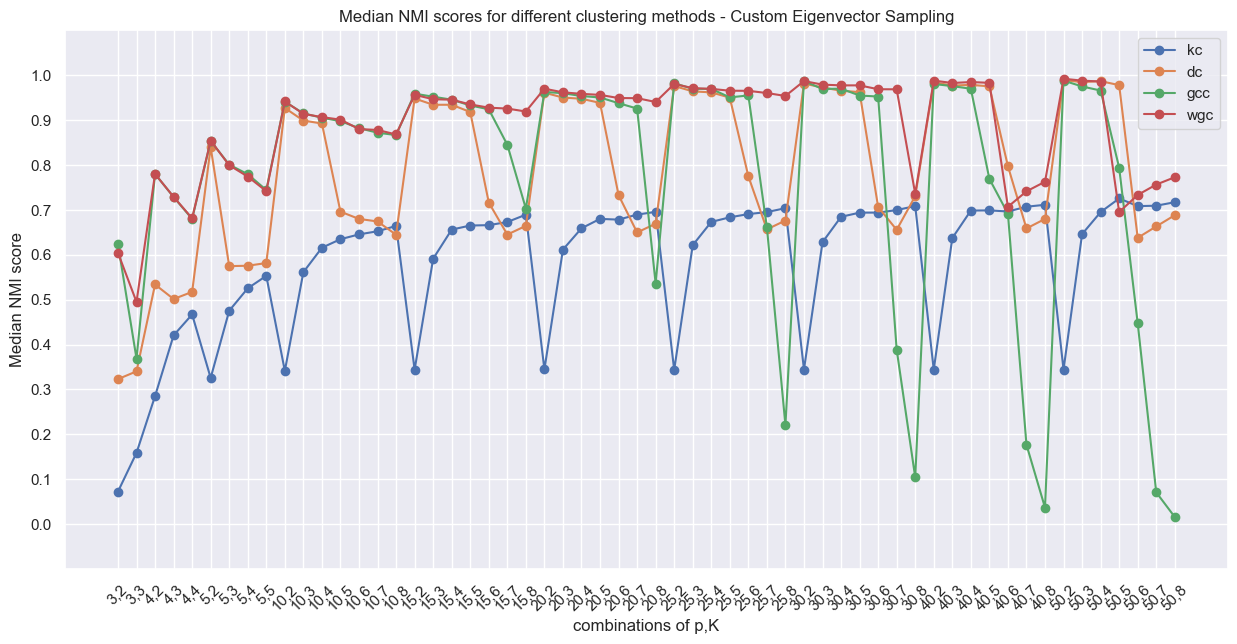

In [62]:
from seaborn import set_theme
set_theme()

c_dict0 = pickle.load(open("clustering_results_0.pkl", "rb"))
plot_dict = get_plot_dict(c_dict0)
median_dict = plot_dict_median(plot_dict)

# pK_comb = [(p, K) for p in [4, 5, 10, 15, 25, 30, 40, 50] for K in [4, 5, 6, 7, 8, 10] if p>=K]
pK_comb = [(p,K) for p,K,method in list(median_dict.keys()) if method == "wgc"]
method_dict = {"kc":kc, "dc":dc, "gcc":gcc, "wgc":wgc}

plt.figure(figsize=(15,7))
plt.title("Median NMI scores for different clustering methods - Custom Eigenvector Sampling")
for method in method_dict.keys():
    plt.plot([median_dict[(p,K,method)] for p,K in pK_comb], linestyle="-", marker="o", label=method)
    plt.legend()
    plt.ylim(-0.1,1.1)
    plt.yticks(np.linspace(0,1,11))
    plt.xticks(range(len(pK_comb)), [str(p)+","+str(K) for p,K in pK_comb], rotation=45)
    plt.xlabel("combinations of p,K")
    plt.ylabel("Median NMI score")
plt.show()

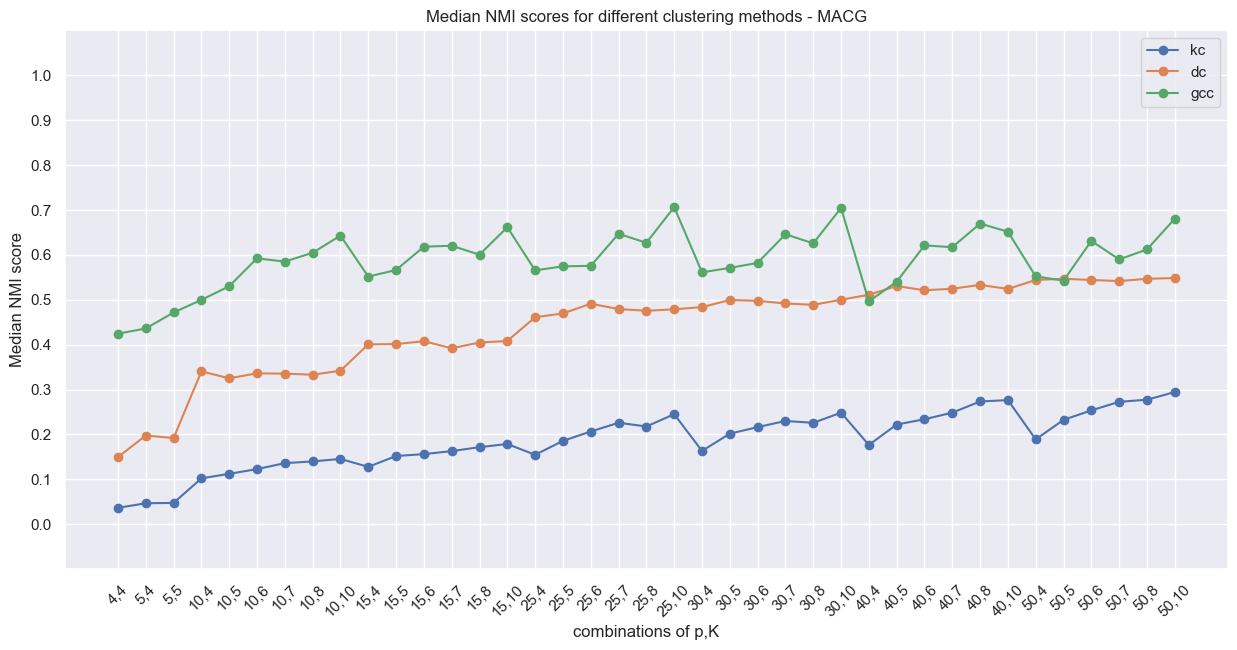

In [61]:
from seaborn import set_theme
set_theme()

c_dict = pickle.load(open("clustering_results_MACG.pkl", "rb"))
plot_dict = get_plot_dict(c_dict)
median_dict = plot_dict_median(plot_dict)

pK_comb = [(p, K) for p in [4, 5, 10, 15, 25, 30, 40, 50] for K in [4, 5, 6, 7, 8, 10] if p>=K]
method_dict = {"kc":kc, "dc":dc, "gcc":gcc}

plt.figure(figsize=(15,7))
plt.title("Median NMI scores for different clustering methods - MACG")
for method in method_dict.keys():
    plt.plot([median_dict[(p,K,method)] for p,K in pK_comb], linestyle="-", marker="o", label=method)
    plt.legend()
    plt.ylim(-0.1,1.1)
    plt.yticks(np.linspace(0,1,11))
    plt.xticks(range(len(pK_comb)), [str(p)+","+str(K) for p,K in pK_comb], rotation=45)
    plt.xlabel("combinations of p,K")
    plt.ylabel("Median NMI score")
plt.show()